In [26]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

Load the Dataset

In [27]:
# Cell 2: Load the dataset
# Make sure 'monthly_sales.csv' is uploaded to your Google Colab environment
from google.colab import files

In [28]:
# Upload the CSV file
uploaded = files.upload()

In [29]:
# Read the CSV file into a pandas DataFrame
data = pd.read_csv('train.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

# Display the first few rows to verify
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


Feature Engineering

In [30]:
# Feature Engineering - Creating a supervised learning problem

# Calculate the difference in sales to create a new feature
data['sales_diff'] = data['sales'].diff()

# Drop the first row with NaN value resulting from the differencing
data.dropna(inplace=True)

# Display the updated DataFrame
data.head()

,store,item,sales,sales_diff
date,,,,
2013-01-02,1,1,11,-2.0
2013-01-03,1,1,14,3.0
2013-01-04,1,1,13,-1.0
2013-01-05,1,1,10,-3.0
2013-01-06,1,1,12,2.0


Create Supervised Data

In [31]:
# Function to create supervised data with lag features
def create_supervised(data, lag=1):
    """
    Transforms time series data into a supervised learning dataset.

    Parameters:
    - data: pandas Series or DataFrame
    - lag: Number of lag periods

    Returns:
    - pandas DataFrame with lagged features
    """
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df_supervised = pd.concat(columns, axis=1)
    df_supervised.fillna(0, inplace=True)
    return df_supervised

In [32]:
# Create supervised data using the last 12 months as lag features
supervised_data = create_supervised(data['sales_diff'], lag=12)

In [33]:
# Display the first few rows of the supervised data
supervised_data.head()

,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff,sales_diff
date,,,,,,,,,,,,,
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
2013-01-03,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2013-01-04,3.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2013-01-05,-1.0,3.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0
2013-01-06,-3.0,-1.0,3.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Split Data into Train and Test Sets

In [34]:
# Splitting the supervised data into training and testing sets

# Use all but the last 12 months for training
train_data = supervised_data[:-12]

# Use the last 12 months for testing
test_data = supervised_data[-12:]

# Display the shapes of the train and test datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (912987, 13)
Test data shape: (12, 13)


Scale Features

In [35]:
# Scaling the features using MinMaxScaler

# Initialize the scaler with the desired feature range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training data
scaler.fit(train_data)

# Transform both training and testing data
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# Optional: Convert scaled data back to DataFrame for better readability
train_scaled_df = pd.DataFrame(train_scaled, columns=supervised_data.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=supervised_data.columns)


Prepare Input and Output Variables

In [36]:
# Preparing input (X) and output (y) variables for training and testing

# Inputs are all columns except the first one (which is the target)
x_train, y_train = train_scaled[:, 1:], train_scaled[:, 0]
x_test, y_test = test_scaled[:, 1:], test_scaled[:, 0]

In [37]:
# Reshape y variables to be 2D arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [38]:
# Display the shapes of the input and output variables
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (912987, 12)
y_train shape: (912987, 1)
x_test shape: (12, 12)
y_test shape: (12, 1)


Create Prediction DataFrame

In [39]:
# Cell 8: Creating a DataFrame to store predictions

# Extract the dates for the last 13 months (including one extra for alignment)
sales_dates = data.index[-13:].to_series().reset_index(drop=True)

# Initialize the prediction DataFrame with dates
predict_df = pd.DataFrame(sales_dates, columns=['date'])

# Display the prediction DataFrame
predict_df.head()


,date
0,2017-12-19
1,2017-12-20
2,2017-12-21
3,2017-12-22
4,2017-12-23


Prepare Actual Sales Data

In [40]:
# Cell 9: Extracting actual sales data for the last 13 months

# Get the actual sales values
actual_sales = data['sales'].values[-13:]

# Display the actual sales
print("Actual Sales:", actual_sales)


Actual Sales: [54 51 63 75 70 76 51 41 63 59 74 62 82]


Train the Linear Regression Model

In [41]:
# Cell 10: Training the Linear Regression model

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(x_train, y_train)

# Make predictions on the test data
lr_predict = lr_model.predict(x_test)

# Display the first few predictions
print("Predictions:", lr_predict[:5])


Predictions: [[0.37235583]
 [0.27869327]
 [0.3153879 ]
 [0.22405752]
 [0.07478487]]


Inverse Transform Predictions

In [42]:
# Cell 11: Inverse transforming the predictions to the original scale

# Concatenate predictions with the input features for inverse scaling
# Since the scaler was fitted on all features, we need to concatenate to maintain the correct shape
lr_predict_combined = np.concatenate((lr_predict, x_test), axis=1)

# Inverse transform the combined data
lr_predict_inverse = scaler.inverse_transform(lr_predict_combined)

# Extract only the first column which corresponds to the target variable
lr_predict_original = lr_predict_inverse[:, 0]

# Display the inverse transformed predictions
print("Inverse Transformed Predictions:", lr_predict_original[:5])


Inverse Transformed Predictions: [ 14.82584687   6.44304761   9.72721716   1.55314783 -11.80675417]


Calculate Predicted Sales

In [43]:
# Cell 12: Calculating the actual predicted sales by adding the differences

# Initialize a list to store the final predicted sales
result_list = []

# Iterate through the predictions and add them to the actual sales to get the predicted sales
for index in range(len(lr_predict_original)):
    result_list.append(lr_predict_original[index] + actual_sales[index])

# Convert the results to a pandas Series
lr_predict_series = pd.Series(result_list, name='linear_prediction')

# Add the predictions to the prediction DataFrame
predict_df = predict_df.join(lr_predict_series)

# Display the updated prediction DataFrame
predict_df.head()

,date,linear_prediction
0,2017-12-19,68.825847
1,2017-12-20,57.443048
2,2017-12-21,72.727217
3,2017-12-22,76.553148
4,2017-12-23,58.193246


from matplotlib import pyplot as plt
_df_0['linear_prediction'].plot(kind='hist', bins=20, title='linear_prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['linear_prediction']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('linear_prediction')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['linear_prediction']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('linear_prediction')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['linear_prediction'].plot(kind='line', figsize=(8, 4), title='linear_prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

Model Evaluation

In [58]:
# Ensure both arrays have the same length by adjusting the slicing:
# Both arrays will now have 12 samples since we want to compare the predictions with actual sales
lr_mse = np.sqrt(mean_squared_error(actual_sales[-12:], lr_predict_original[-12:]))  # Last 12 samples
lr_mae = mean_absolute_error(actual_sales[-12:], lr_predict_original[-12:])
lr_r2 = r2_score(actual_sales[-12:], lr_predict_original[-12:])

# Print the evaluation metrics
print(f"Linear Regression RMSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R² Score: {lr_r2}")


Linear Regression RMSE: 64.362054151124
Linear Regression MAE: 61.614477881722046
Linear Regression R² Score: -29.629846372042078


Plot Actual vs Predicted Sales

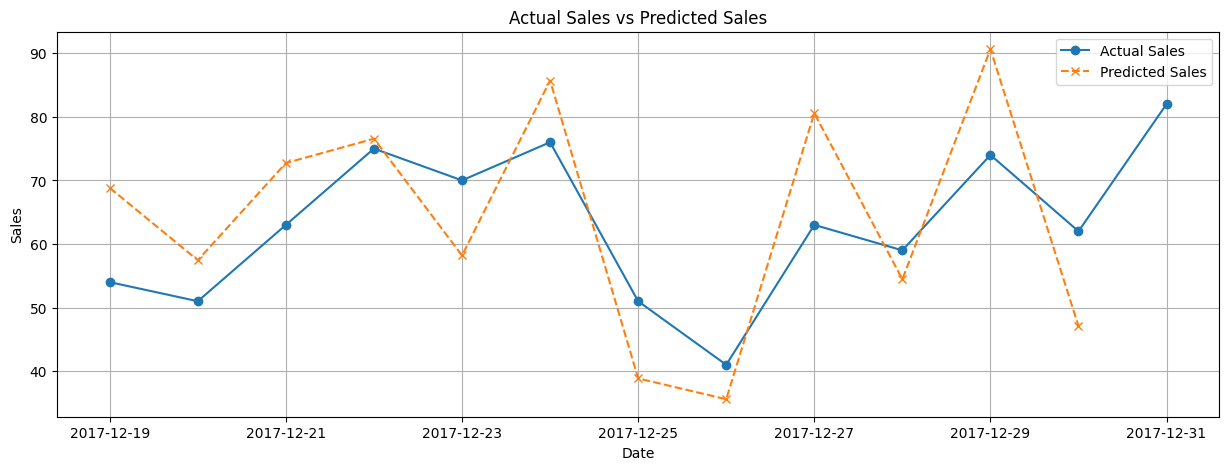

In [55]:
# Cell 14: Plotting Actual Sales vs Predicted Sales

plt.figure(figsize=(15, 5))
plt.plot(data.index[-13:], actual_sales, label='Actual Sales', marker='o')
plt.plot(predict_df['date'], predict_df['linear_prediction'], label='Predicted Sales', linestyle='--', marker='x')
plt.title('Actual Sales vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()